Exercise 2.5

In this notebook we have implemented a simple bandit algorithm described on page 32 for 10-armed Testbed problem in Chapter 2.3 with Non-Stationary Value Function Distribution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper")
sns.set_theme("paper")
%matplotlib inline

In [2]:
num_testbed = 1000 # 2000
num_armed_bandits = 10
num_experience_steps = 2000 # 10000
initial_value_multiplier = 0.0
armed_bandit_dynamics = 0.01 # standard deviation of evolution

testbed = np.random.normal(size=(num_testbed, num_armed_bandits))
action_value_estimates = initial_value_multiplier* np.ones_like(testbed)
action_select_counts = np.ones_like(testbed)

In [3]:
def step_multi_armed_bandit(optimal_action_value, action_value, action_select_count, epsilon=0.0, alpha=0.0):
    random_rewards = np.random.normal(loc=optimal_action_value)
    # action probabilities are calculated based on epsilon factor
    action_probabilities = np.array([1 - epsilon + epsilon/len(action_value) if idx==np.argmax(action_value) else epsilon/len(action_value) for idx in range(len(action_value)) ])
    action_select = np.random.choice(a=range(len(action_value)), p=action_probabilities)
    # applying incremental update formula in Equation 2.3
    if alpha == 0:
        action_value[action_select] = action_value[action_select] + (1.0/(action_select_count[action_select]))*(random_rewards[action_select]-action_value[action_select]) 
    else:
        action_value[action_select] = action_value[action_select] + alpha*(random_rewards[action_select]-action_value[action_select]) 
    action_select_count[action_select] += 1
    return action_value, action_select_count, random_rewards[action_select], int(action_select==np.argmax(optimal_action_value))

def run_multi_armed_bandit(optimal_action_value, action_value, action_select_count, 
                           epsilon=0.0, num_iters=100, evalution_std=0.0, alpha=0.0):
    reward_history = []
    optimal_action_history = []
    loss_history = []
    for iter in range(num_iters):
        optimal_action_value += np.random.normal(loc=np.zeros_like(optimal_action_value), scale=evalution_std)
        action_value, action_select_count, test_reward, test_score = step_multi_armed_bandit(optimal_action_value, action_value, 
                                                                                               action_select_count, epsilon, alpha)
        reward_history.append(test_reward)
        optimal_action_history.append(test_score)
        loss_history.append(np.sqrt(np.mean((optimal_action_value-action_value)**2)))
    return reward_history, optimal_action_history, loss_history

def experiment(optimal_action_values, action_values, action_select_counts, 
               epsilon=0.0, num_iters=100, evalution_std=0.0, alpha=0.0):
    rewards = []
    scores = []
    l2_loss = []
    for optimal_action_value, action_value, action_select_count in zip(optimal_action_values, action_values, action_select_counts):
        reward_history, score_history, loss = run_multi_armed_bandit(optimal_action_value, action_value,
                                                                     action_select_count, epsilon, num_iters, 
                                                                     evalution_std=evalution_std, alpha=alpha)
        rewards.append(reward_history)
        scores.append(score_history)
        l2_loss.append(loss)
    return np.array(rewards), np.array(scores), np.array(l2_loss)

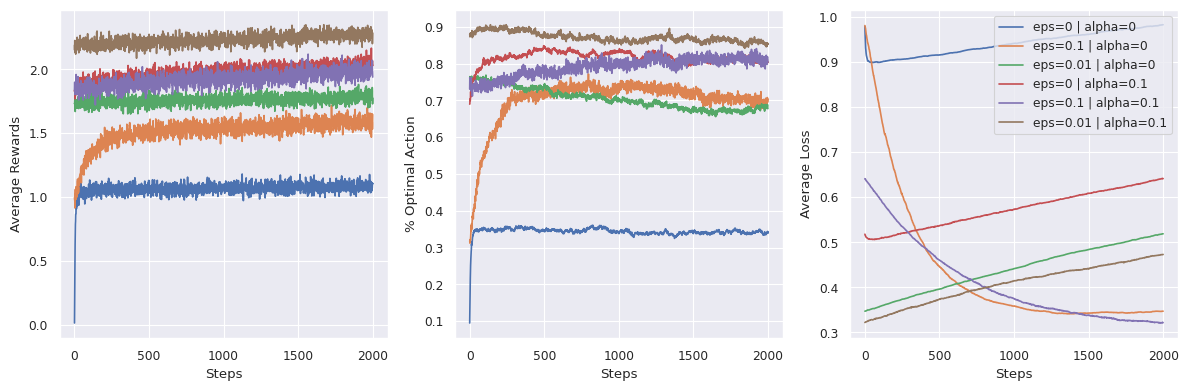

In [4]:
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# for eps in np.logspace(-10, -1e-4, num=4, base=2):
for alpha in [0, 0.1]:
    for eps in [0, 1e-1, 1e-2]:
        rewards, scores, losses = experiment(optimal_action_values=testbed, action_values=action_value_estimates, 
                                            action_select_counts=action_select_counts, epsilon=eps, num_iters=num_experience_steps,
                                            evalution_std=armed_bandit_dynamics, alpha=alpha)
        axis[0].plot(np.arange(0, num_experience_steps), np.mean(rewards, axis=0, keepdims=True).reshape(-1), label=f"eps={np.round(eps, decimals=3)} | alpha={alpha}")
        axis[1].plot(np.arange(0, num_experience_steps), np.mean(scores, axis=0, keepdims=True).reshape(-1), label=f"eps={np.round(eps, decimals=3)} | alpha={alpha}")
        axis[2].plot(np.arange(0, num_experience_steps), np.mean(losses, axis=0, keepdims=True).reshape(-1), label=f"eps={np.round(eps, decimals=3)} | alpha={alpha}")

        axis[0].set_xlabel("Steps")
        axis[0].set_ylabel("Average Rewards")

        axis[1].set_xlabel("Steps")
        axis[1].set_ylabel("% Optimal Action")

        axis[2].set_xlabel("Steps")
        axis[2].set_ylabel("Average Loss")
fig.tight_layout()
plt.legend()
plt.show()